# Laboratorium 3

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


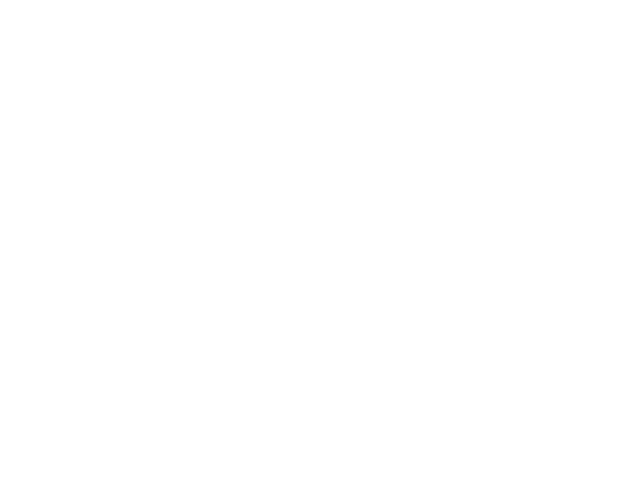

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


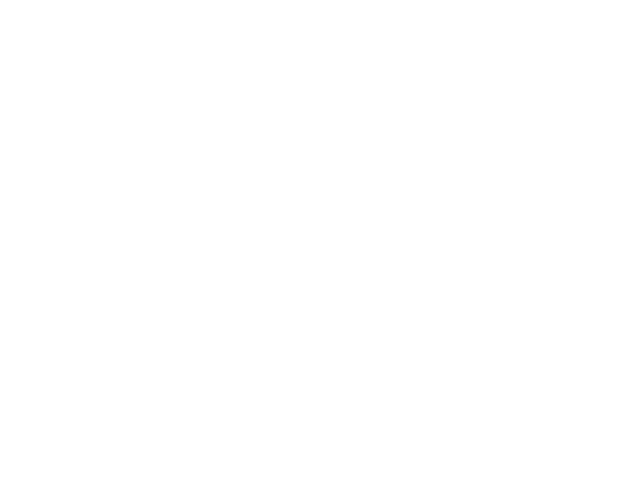

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


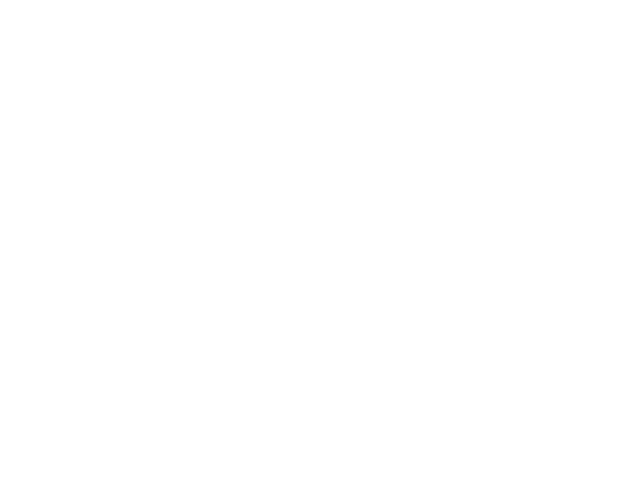

In [5]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


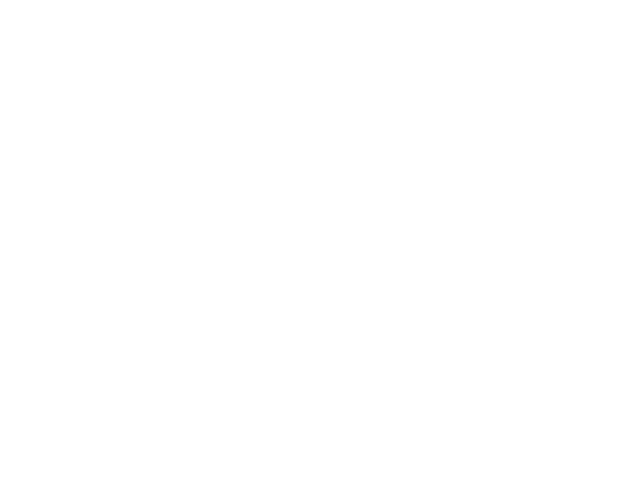

In [6]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

#### Global variables

In [7]:
from enum import Enum, auto
from random import uniform

eps = 10 ** (-9)

### DEPRECATED ###
class Side(Enum):
    LEFT = auto()
    RIGHT = auto()    
    
class Orientation(Enum):
    LEFT = auto()
    COLLINEAR = auto()
    RIGHT = auto()

#### Helper Functions:
- determinant
- orientation

In [8]:
def det(a,b,c):
    return a.x * b.y + a.y * c.x + b.x * c.y - b.y * c.x - a.y * b.x - a.x * c.y

def orient(a, b, c):
    determinant = det(a, b, c)
    
    if determinant < -eps:
        return Orientation.RIGHT
    elif determinant > eps:
        return Orientation.LEFT
    else:
        return Orientation.COLLINEAR

def orientation_rel_to_line(point, segment):
    orientation = det(segment.start, segment.end, point)
    if orientation < -eps:
        return -1
    elif orientation > eps:
        return 1
    else:
        return 0

### Swipe-Algorithm Data Classes
- Point -- class for representing 2D points.
- Segment -- class for representing line segments.
- StateSegment -- class defining objects held in T.
- EventType - enum holding information about type of event.
- Event -- class defining objects in Q.
- Step -- used mainly for visualization.

In [9]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def to_tuple(self):
        return self.x, self.y
    
    def to_np_array(self):
        return np.array(self.to_tuple)
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __hash__(self):
        return hash(self.to_tuple())
    
class Segment:
    def __init__(self, start, end):
        self.start = start
        self.end = end
    
    def to_tuple(self):
        return self.start.to_tuple(), self.end.to_tuple()
    
    def __eq__(self, other):
        return self.end == other.end and self.start == other.start
    
    def __repr__(self, *args, **kwargs):
        return "[" + str(self.start) + ", " + str(self.end) + "]"
    
    def __hash__(self):
        return 13 * hash(self.start) + 53 * hash(self.end)

class EventType(Enum):
    start = 1
    intersection = 2
    end = 3
    
    def __lt__(self, other):
        return self.value < other.value

class StateSegment:
    def __init__(self, segment):
        self.segment = segment
        self.start = segment.start
        self.end = segment.end
        self.orientation_point = self.start
    
    ### Somewhat tricky code
    ### In order to model "swap" we maintain "orientation_point"
    ### During swap we change orientation_point and then orient is 0 <=> collinear
    ### If that's the case we simply check if orientation relative to other line segment 
    ### and end of current line segment is 1 <=> Orientation.RIGHT.
    def __lt__(self, other):
        orientation = None
        if self.orientation_point.x >= other.orientation_point.x:
            orientation = orientation_rel_to_line(self.orientation_point, other.segment)
        else:
            orientation = -orientation_rel_to_line(other.orientation_point, self.segment)
        
        return (orientation == 1) or (orientation == 0 and orientation_rel_to_line(self.end, other.segment) == 1)
    
    def __eq__(self, other):
        return self.segment == other.segment
    
    def __hash__(self):
        return hash(self.segment)
    
    def __le__(self, other):
        return self < other or self == other
    
class Event:
    def __init__(self, point, segments, event_type):
        self.point = point
        self.segments = segments
        self.type = event_type
    
    def __lt__(self, other):
        return (self.point.x < other.point.x) or (self.point.x == other.point.x and self.point.y < other.point.y) or (self.point.x == other.point.x and self.point.y == other.point.y and self.type < other.type)
    
    def __hash__(self):
        return hash(self.point)
    
    def __eq__(self, other):
        return self.point == other.point and self.type == other.type
    
class Intersection(Event):
    def __init__(self, point, segment1, segment2):
        super().__init__(point, (segment1, segment2), EventType.intersection)
        self.segment1 = segment1
        self.segment2 = segment2
        
    def __repr__(self):
        return "Intersection in point " + str(self.point) + " between segment: " + str(self.segment1) + " and: " + str(
            self.segment2)
    
    def __hash__(self):
        return hash(self.segments)
    
class Step:
    def __init__(self, sweep_point, state = [], current_intersections = []):
        self.sweep_point = sweep_point.to_tuple()
        self.state = state
        if self.state is None:
            self.state = []
        self.current_intersections = current_intersections
    
    def state_to_tuple(self):
        return list(state_segment.segment.to_tuple() for state_segment in self.state)
    
    def get_scene_elements(self):
        return self.sweep_point, self.state_to_tuple(), self.current_intersections

### Helper functions for swiping algorithm
- intersection 
- check_intersection  
- process_segment 

In [10]:
### Calculates intersection between two line segments
### if exists returns tuple -> Point
### otherwise None
def intersection(a, b, eps = 1e-6):
    r = (a.end.x - a.start.x, a.end.y - a.start.y)
    s = (b.end.x - b.start.x, b.end.y - b.start.y)
    
    rxs = r[0] * s[1] - r[1] * s[0] 
    
    if rxs > eps or rxs < -eps:
        q_p = (b.start.x - a.start.x, b.start.y - a.start.y)
        t = (q_p[0] * s[1] - q_p[1] * s[0]) / rxs
        u = (q_p[0] * r[1] - q_p[1] * r[0]) / rxs
        
        if (0. <= t <= 1.) and (0. <= u <= 1.):
            return round(a.start.x + t*r[0], 8), round(a.start.y + t*r[1], 8)
        else:
            return None
    else:
        return None

### Checks for intersections between two line segments 
### if found inserts intersection into Q as future event.
def check_intersection(segment1, segment2, events, intersections):
    if (not segment1 is None) and (not segment2 is None):
        intersection_point = intersection(segment1.segment, segment2.segment)
        if intersection_point and intersection_point not in intersections:
            intersections.add(intersection_point)
            
            event = Intersection(Point(*intersection_point), segment1.segment, segment2.segment)
            events.insert(event)
            
### Checks for intersections with neighbours of supplied segment
### which is added to T,
### If found any intersection inserts them into Q.
def process_segment(segment, state, events, intersections):
    state.insert(segment)
    
    neighbour1 = state.successor(segment)
    neighbour2 = state.predecessor(segment)
    
    check_intersection(segment, neighbour1, events, intersections)
    check_intersection(segment, neighbour2, events, intersections)

In [11]:
from rb_tree import *

def sweep(lines):
    def initialize_structures():
        Q = RBTree() ### Event Queue
        T = RBTree() ### State Structure
    
        steps = [] ### For visualization
        intersections = set() ### Result set
        
        return Q, T, intersections, steps
    
    Q, T, intersections, steps = initialize_structures()
    
    ### Inserts events (points) into Q
    for segment in lines:
        event_start = Event(segment.start, segment, EventType.start)
        event_end = Event(segment.end, segment, EventType.end)
        Q.insert(event_start)
        Q.insert(event_end)
        
    ### Extract leftmost event up to the point when there's none.
    event = Q.minimum()    
    while not event is None:
        ### THREE CASES
        
        ### FIRST CASE
        ### Event is start of a line segment --> check for intersections with its neighbours and if there are any 
        ### insert them into Q
        if event.type == EventType.start:
            segment = StateSegment(event.segments)
            process_segment(segment, T, Q, intersections)
        ### SECOND CASE
        ### Event is end of a line segment (s) --> if neighbours of s intersect
        ### insert them into Q if not already in there
        elif event.type == EventType.end:
            segment = event.segments
            state_segment = StateSegment(segment)
            
            neighbour1 = T.successor(state_segment)
            neighbour2 = T.predecessor(state_segment)
            
            T.remove(state_segment)
            
            check_intersection(neighbour1, neighbour2, Q, intersections)
        ### THIRD CASE
        ### Event is intersection of line segments (s, s') --> 
        ### Swap s and s' in T and then check for intersections
        ### with new neighbours.
        else:
            state_segment1 = StateSegment(event.segment1)
            state_segment2 = StateSegment(event.segment2)
            
            T.remove(state_segment1)
            T.remove(state_segment2)
            
            state_segment1.orientation_point = event.point
            state_segment2.orientation_point = event.point
            
            process_segment(state_segment1, T, Q, intersections)
            process_segment(state_segment2, T, Q, intersections)
        
        ### Visualization specific code
        nodes = T.nodes()
        steps.append(Step(event.point, nodes if (not nodes is None) else [] , list(intersections)))
        
        ### Move on to next point from Q
        Q.remove(event)
        event = Q.minimum()
            
    return intersections, steps

### Few useful functions
- read_lines
- visualize 
- animate

In [12]:
def read_lines(filename):
    segments = []
    
    with open(filename) as f:
        plot = Plot(json=f.read())
        segments = plot.scenes[0].lines[0].lines
    
    for i in range(len(segments)):
        segments[i].sort()
        segments[i][0] = Point(*segments[i][0])
        segments[i][1] = Point(*segments[i][1])
        segments[i] = Segment(*segments[i])
    
    return segments

def visualize(segments, intersections):
    lines = [segment.to_tuple() for segment in segments]
    
    scene = Scene([PointsCollection(intersections)], [LinesCollection(lines)])
    plot = Plot([scene])
    plot.draw()

### self-explanatory code..
def animate(lines, steps):
    y_min, y_max = (10**7, -10**7)
    
    for i in lines:
        y_min = min(y_min, min(i.start.y, i.end.y))
        y_max = max(y_max, max(i.start.y, i.end.y))
    
    scenes = []
    segments = [segment.to_tuple() for segment in lines]

    for i in steps:
        sweep_point, state_segments, intersections =  i.get_scene_elements()
        scenes.append(Scene([PointsCollection(intersections, color='green'), PointsCollection([sweep_point], color='red')], [LinesCollection(segments, linestyle='dashed'), LinesCollection(state_segments, color='black'), LinesCollection([[(sweep_point[0], y_min), (sweep_point[0], y_max)]], linestyle='dashed', color='red')]))
    
    plot = Plot(scenes)
    
    return plot

In [26]:
tests = ['test_1.json', 'test_2.json']

lines = read_lines(tests[0]) 

intersections, steps = sweep(lines)
intersections = list(intersections)

<IPython.core.display.Javascript object>


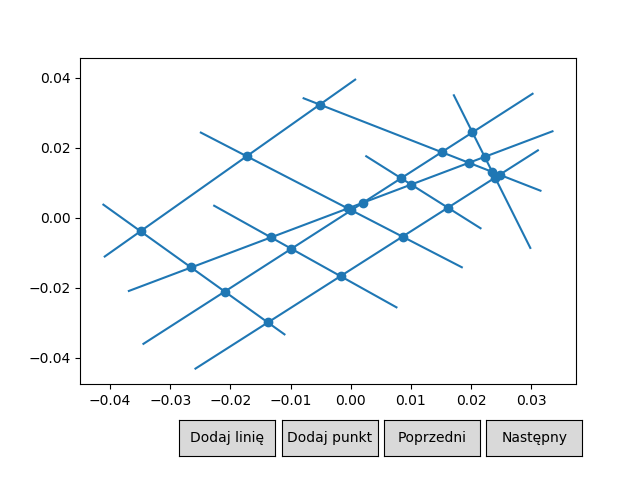

In [27]:
visualize(lines, intersections)

<IPython.core.display.Javascript object>


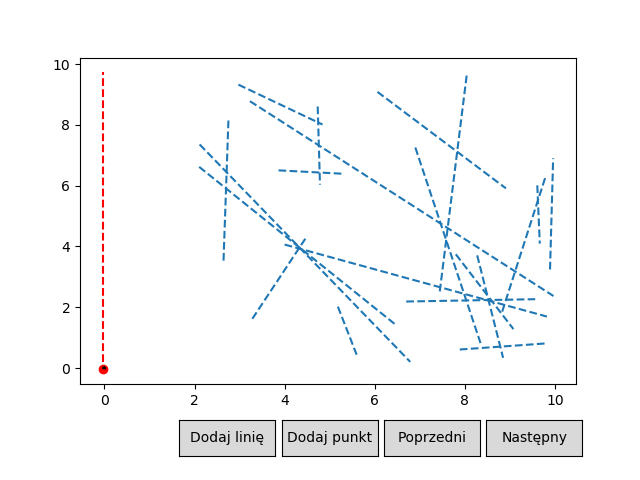

In [23]:
%matplotlib notebook

# lines = generate_random_lines(Point(0, 0), Point(10, 10), 20)

plot = animate(lines, steps)
plot.draw()

### Helper functions 
- parsing lines to points and the other way around
- generating lines

In [16]:
### Returns list of lines
def generate_random_lines(lower_left : Point, upper_right : Point, N):
    lines = set()
    for _ in range(N):
        x1 = uniform(lower_left.x, upper_right.x)
        y1 = uniform(lower_left.y, upper_right.y)
    
        x2 = uniform(x1, upper_right.x)
        y2 = uniform(lower_left.y, upper_right.y)
        
        left = Point(x1, y1)
        right = Point(x2, y2)
        
        lines.add(Segment(left, right))
    
    return list(lines)

### Returns list of line segments
def parse_lines_collections(lines_collections):
    lines = []
    
    for lines_collection in lines_collections:
        for line in lines_collection.lines:
            a, b = line[0], line[1]
            dx = a[0] - b[0]
            
            ### Omit vertical line segments.
            if -eps <= dx <= eps:
                continue
            
            left, right = a, b
            if a[0] > b[0]:
                left, right = b, a
            
            left_end = Point(left[0], left[1])
            right_end = Point(right[0], right[1])
            
            lines.append(Segment(left_end, right_end))
            
    return lines

### returns list of point tuples
def lines_to_point_tuples(lines):
    points = []
    
    for line in lines:
        left, right = line[0], line[1]
        
        points.append(left.to_tuple())
        points.append(right.to_tuple())
    
    return points

### returns list of points
def lines_to_points(lines):
    points = []
    
    for line in lines:
        left, right = line.start, line.end
        
        points.append(left)
        points.append(right)
        
    return points